In [476]:
import os

def run_fast_scandir(dir, ext):    
    subfolders, datafiles = [], []

    for f in os.scandir(dir):
        if f.is_dir():
            subfolders.append(f.path)
        if f.is_file():
            if os.path.splitext(f.name)[1].lower() in ext:
                datafiles.append(f.path)

    for dir in list(subfolders):
        sf, f = run_fast_scandir(dir, ext)
        subfolders.extend(sf)
        datafiles.extend(f)
    return subfolders, datafiles

In [477]:
def pick_channels(ch_labels, desired_channels):
    ch_idx = []    
    for dc in desired_channels:
        for i, c in enumerate(ch_labels):
            if dc in c:
                ch_idx.append(i)
    return ch_idx

# **Importing signal**

## Signal info

In [478]:
import mne
import numpy as np

file = "Sara_session_01.edf"
raw_eeg = mne.io.read_raw_edf(f"C:/Users/migue/OneDrive/Ambiente de Trabalho/Tese/EEG Data/{file}", preload=True)

print("\n", raw_eeg.info.keys())
print("\n", raw_eeg.info)

ch = raw_eeg.info["ch_names"] # Channel labels
fs = raw_eeg.info["sfreq"]

print("\nChannel labels: ", ch)

Extracting EDF parameters from C:\Users\migue\OneDrive\Ambiente de Trabalho\Tese\EEG Data\Sara_session_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1366271  =      0.000 ...   667.125 secs...

 dict_keys(['acq_pars', 'acq_stim', 'ctf_head_t', 'description', 'dev_ctf_t', 'dig', 'experimenter', 'utc_offset', 'device_info', 'file_id', 'highpass', 'hpi_subsystem', 'kit_system_id', 'helium_info', 'line_freq', 'lowpass', 'meas_date', 'meas_id', 'proj_id', 'proj_name', 'subject_info', 'xplotter_layout', 'gantry_angle', 'bads', 'chs', 'comps', 'events', 'hpi_meas', 'hpi_results', 'projs', 'proc_history', 'custom_ref_applied', 'sfreq', 'dev_head_t', 'ch_names', 'nchan'])

 <Info | 7 non-empty values
 bads: []
 ch_names: EEG T7'', EEG TP7'', EEG P7'', EEG PO7'', EEG CP5'', EEG P5'', ...
 chs: 38 EEG
 custom_ref_applied: False
 highpass: 0.1 Hz
 lowpass: 538.0 Hz
 meas_date: 2024-04-08 16:23:54 UTC
 nchan: 38
 projs: []
 sfreq: 2048.0 

# **Analysing signal quality and pre-processing data accordingly**

## Re-referencing

In [479]:
'''
car = mne.pick_channels(ch, include = [], exclude = ['EEG FP1', 'EEG FP2','dc01+', 'dc02+', 'MKR+'])
ch_list = [ch[c] for c in car] 
eeg = raw.copy().pick(ch_list)
eeg.set_eeg_reference(ref_channels = 'ch_list')
'''
exclude_ch = [" FP1", " FP2"]
exclude_ch_idx = pick_channels(ch, exclude_ch)

## Checking if the recorded signal is an EEG (1/f shape)

### Designing the band pass filter

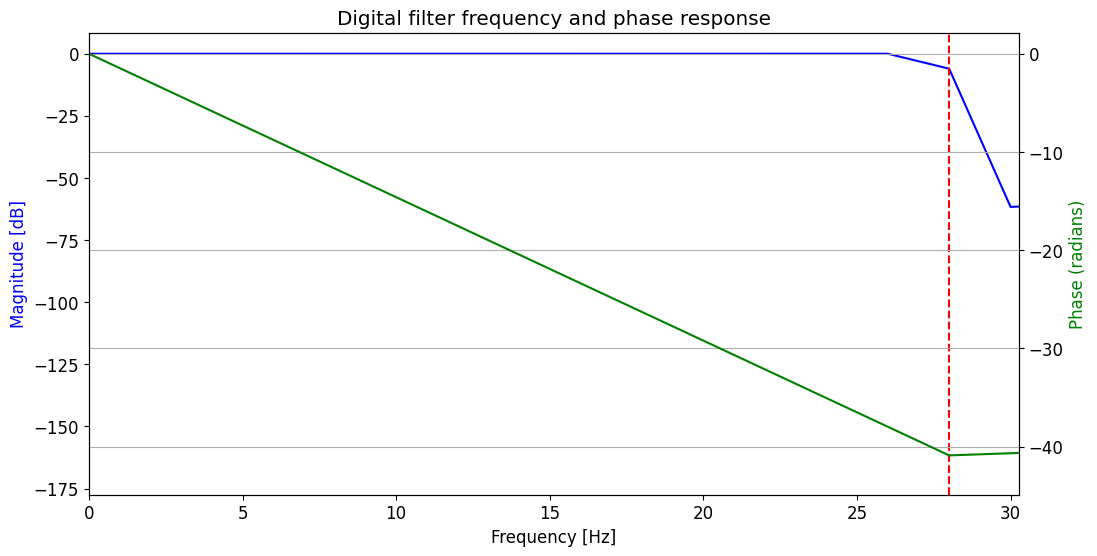

In [480]:
import scipy
from scipy.signal import filtfilt, firwin, freqz

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Designing a low-pass FIR filter at 28 Hz
nyquist = fs/2
lowcut = 28
numtaps = 3001 # Order
filt = firwin(numtaps, lowcut/nyquist, pass_zero=True)  
'''
pass_zero -> If True, the gain at frequency 0 (DC) is 1, creating a low-pass filter.
              If False, the DC gain is 0, creating a high-pass filter.
'''

# Ploting the frequency response of the filter
w, h = freqz(filt) # The frequency response is returned as a tuple (w, h), where w is the array of frequencies and h is the array of complex coeficients (w: rad/samples)

fig, ax1 = plt.subplots(figsize = (12,6))

ax1.set_title('Digital filter frequency and phase response')
ax1.plot(w*fs/(2*np.pi), 20 * np.log10(abs(h)), 'b')
ax1.set_ylabel('Magnitude [dB]', color='b')
ax1.set_xlabel('Frequency [Hz]')
ax1.set_xticks(np.arange(0,lowcut * 4/3.7, 5))
ax1.axvline(x = lowcut, color = 'r', linestyle = '--')

ax2 = ax1.twinx()
ax2.plot(w*fs/(2*np.pi), np.unwrap(np.angle(h)), 'g')
ax2.set_ylabel('Phase (radians)', color='g')
ax2.grid(True)
ax2.axis('tight')
ax2.set_xlim(0, lowcut * 4/3.7)

plt.show()

# Applying the filter to the signal using filtfilt
# EEG shape: (channels, samples)
eeg_ch_idx = mne.pick_channels(ch, include = [], exclude = ['dc01+', 'dc02+', 'MKR+'])
filt_eeg = filtfilt(filt, 1, raw_eeg.get_data(picks = eeg_ch_idx), axis = 1)


### Apllying the FFT on the EEG signal

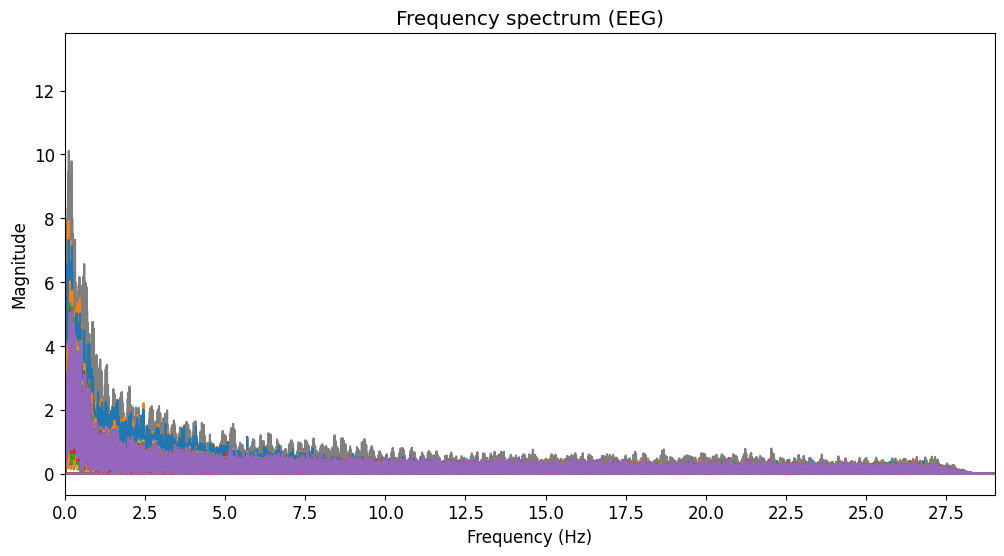

In [481]:
X = np.fft.fft(filt_eeg,axis = 1)

# Compute the frequency vector
freqs = np.fft.fftfreq(np.size(X,1), 1/fs)

# Plot the frequency spectrum
figure(figsize = (12,6))
plt.plot(freqs, np.abs(X.T))
plt.title("Frequency spectrum (EEG)")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, lowcut + 1)
plt.xticks(np.arange(0, lowcut + 1, 2.5)) 
plt.show()

## Analysing electrode smearing/bridging

Creating RawArray with float64 data, n_channels=35, n_times=1366272
    Range : 0 ... 1366271 =      0.000 ...   667.125 secs
Ready.
Local minimum 1.3285376861000213 found
Bridge detected between P7 and P5
Bridge detected between PO7 and PO5
Bridge detected between POz and Oz
Bridge detected between CP4 and CP6
Bridge detected between PO6 and PO8


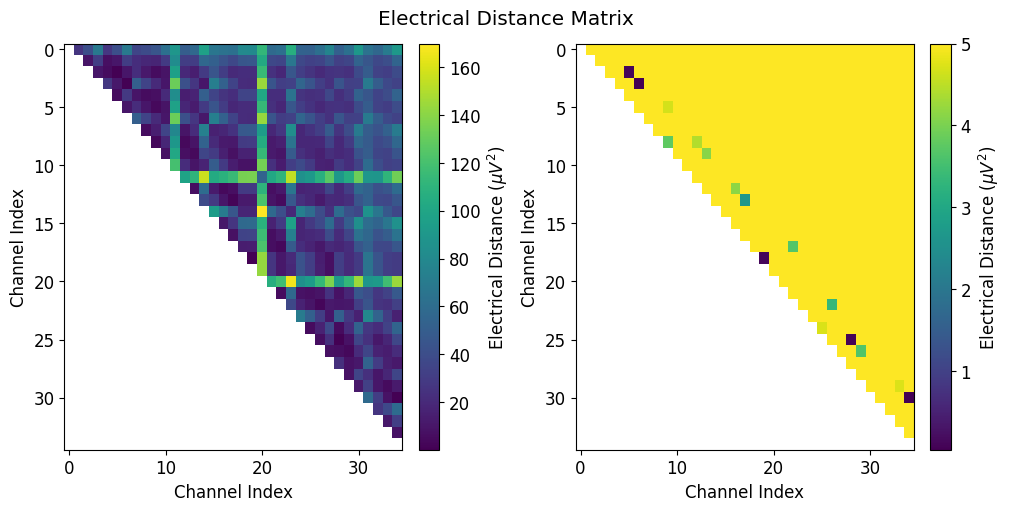

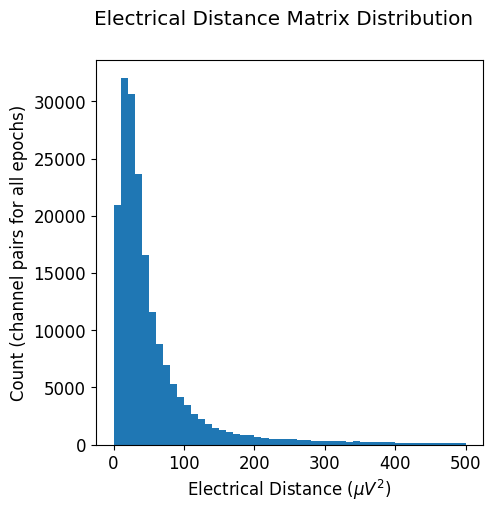

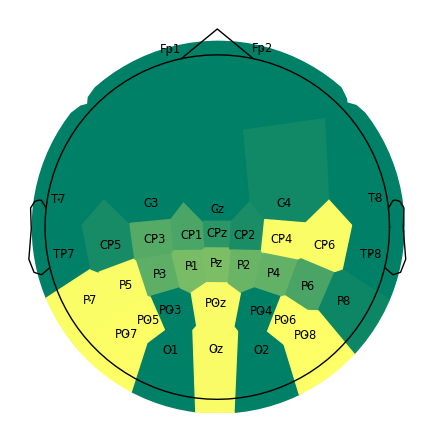

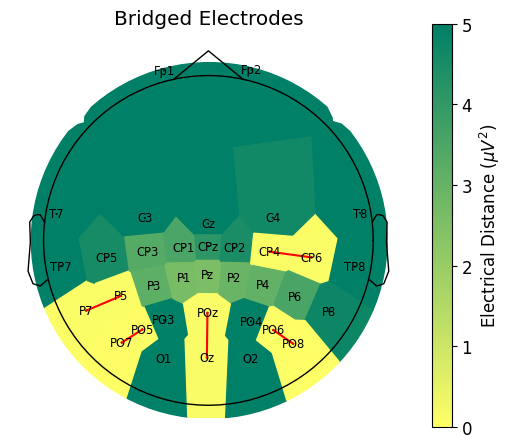

In [482]:
cust_ch = [ch[c].split("EEG ")[1] for c in eeg_ch_idx if ("EEG " in ch[c])]
clean_ch = [c.split("''")[0] for c in cust_ch]

for c in range(len(clean_ch)):
    if clean_ch[c] == 'FP1':
        clean_ch[c] = 'Fp1'
    elif (clean_ch[c] == 'FP2'):
        clean_ch[c] = 'Fp2'

ch_types = ['eeg'] * len(clean_ch)

new_info = mne.create_info(ch_names = clean_ch, sfreq = fs, ch_types = ch_types)
eeg_smearing = mne.io.RawArray(filt_eeg, new_info)
eeg_smearing.set_montage('standard_1005')

## Examine an Electrical Distance Matrix

ed_data = mne.preprocessing.compute_bridged_electrodes(eeg_smearing)
bridged_idx, ed_matrix = ed_data

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), layout="constrained")
fig.suptitle("Electrical Distance Matrix")

# take median across epochs, only use upper triangular, lower is NaNs
ed_plot = np.zeros(ed_matrix.shape[1:]) * np.nan
triu_idx = np.triu_indices(ed_plot.shape[0], 1)
for idx0, idx1 in np.array(triu_idx).T:
    ed_plot[idx0, idx1] = np.nanmedian(ed_matrix[:, idx0, idx1])

# plot full distribution color range
im1 = ax1.imshow(ed_plot, aspect="auto")
cax1 = fig.colorbar(im1, ax=ax1)
cax1.set_label(r"Electrical Distance ($\mu$$V^2$)")

# plot zoomed in colors
im2 = ax2.imshow(ed_plot, aspect="auto", vmax=5)
cax2 = fig.colorbar(im2, ax=ax2)
cax2.set_label(r"Electrical Distance ($\mu$$V^2$)")
for ax in (ax1, ax2):
    ax.set_xlabel("Channel Index")
    ax.set_ylabel("Channel Index")

## Examine the Distribution of Electrical Distances

fig, ax = plt.subplots(figsize=(5, 5))
fig.suptitle("Electrical Distance Matrix Distribution")
ax.hist(ed_matrix[~np.isnan(ed_matrix)], bins=np.linspace(0, 500, 51))
ax.set_xlabel(r"Electrical Distance ($\mu$$V^2$)")
ax.set_ylabel("Count (channel pairs for all epochs)")

## Plot Electrical Distances on a Topomap

mne.viz.plot_bridged_electrodes(
    eeg_smearing.info,
    bridged_idx,
    ed_matrix, 
    title = "Bridged Electrodes",
    topomap_args=dict(vlim=(None, 5), 
                 size = 10,
                 sphere=(-0.001, 0.0001, 0.12, 0.2)),
)

## Interpolating bridged channels

In [483]:
bridged_idx = ed_data[0]

num_smeared_electrodes = 0
for i in bridged_idx:
     num_smeared_electrodes += len(i)

print("Number of connections: ", num_smeared_electrodes)

'''
if(len(bridged_idx) > 0 and num_smeared_electrodes <= 10):
    filt_eeg = mne.preprocessing.interpolate_bridged_electrodes(
        eeg_smearing.copy(), 
        bridged_idx=bridged_idx
    )
    
    filt_eeg = filt_eeg.get_data()
'''

Number of connections:  10


'\nif(len(bridged_idx) > 0 and num_smeared_electrodes <= 10):\n    filt_eeg = mne.preprocessing.interpolate_bridged_electrodes(\n        eeg_smearing.copy(), \n        bridged_idx=bridged_idx\n    )\n    \n    filt_eeg = filt_eeg.get_data()\n'

## Re-referencing

In [484]:
'''
car = np.zeros(np.shape(filt_eeg))
for dt in range(np.size(filt_eeg,1)):
    ch_sum = []
    for c in range(np.size(filt_eeg,0)):
        if c not in exclude_ch_idx:
            ch_sum.append(filt_eeg[c,dt])
    car[:,dt] = filt_eeg[:,dt] - np.mean(ch_sum)

filt_eeg = car
'''

'\ncar = np.zeros(np.shape(filt_eeg))\nfor dt in range(np.size(filt_eeg,1)):\n    ch_sum = []\n    for c in range(np.size(filt_eeg,0)):\n        if c not in exclude_ch_idx:\n            ch_sum.append(filt_eeg[c,dt])\n    car[:,dt] = filt_eeg[:,dt] - np.mean(ch_sum)\n\nfilt_eeg = car\n'

## Isolating the LDR channel

In [485]:
def plot_isolated_signal(time, signal, th, title):
    figure(figsize = (400,20))
    plt.plot(time, signal, linewidth = 2);
    plt.title(title, fontsize = 100, fontweight = 'bold')
    plt.xlabel('Time (min)', fontsize = 85, fontweight = 'bold')
    plt.ylabel('Voltage (V)', fontsize = 85, fontweight = 'bold')
    plt.xticks(np.arange(0, np.max(time), 0.05), fontsize = 30)
    plt.yticks(np.arange(np.min(signal), np.max(signal), 0.1), fontsize = 30)
    plt.xlim([0,max(time)])
    plt.axhline(y = th, color = 'k', linestyle = '--', linewidth = 2)
    plt.grid()

In [486]:
ldr_ch_idx = mne.pick_channels(ch, include = ['dc01+'])
ldr_ch = raw_eeg.get_data(picks = ch[ldr_ch_idx[0]])
if (np.mean(ldr_ch) < 0): # If the polarity was inverted
    print("Inverting signal...")
    ldr_ch = ldr_ch * -1
''' 
The bright square (more light) will decrease the resistance of the LDR, thus producing more voltage
aproximating 2.4V if the polarity of the component was right or -2.4V if the polarity was inverted

The dark square will increase the resistance to the MOhm range and cause the signal to be almost 0.
This is because all the voltage will be sucked by the first component (LDR) of the voltage divider.
'''

time = np.arange(0, np.size(ldr_ch,1)/fs, 1/fs) # Time vector of the acquisition in s
th = 1.2 # y value threshold to segment signal
#th = 0.8
#plot_isolated_signal(time/60, ldr_ch[0][:], th, "LDR channel") # time/60 = timevector in minutes

## Filtering the LDR channel (Median filter)

In [487]:
#n_filt = 201
n_filt = 21
filt_ldr_ch = scipy.signal.medfilt(ldr_ch[:][0], n_filt) 
# A 201 points median filter seems to be enough to smooth the signal without causing phase shifts
# The filter applies a zero pad automatically at the edges

plot_isolated_signal(time/60, filt_ldr_ch, th, "Filtered LDR channel")

# **Segmenting the EEG**

## Detecting the edges on the LDR channel

In [488]:
def condition_segmentation(ldr, th):
    
    last_low = True
    last_high = False
    
    rising_edges = []
    falling_edges = []

    for index, val in enumerate(ldr):

        if val >= th: # Possible rising edge
            if last_low: # Found rising edge
                rising_edges.append(index) 
            
            last_low = False
            last_high = True
        
        elif val <= th: # Possible falling edge
            if last_high:
                falling_edges.append(index)

            last_low = True
            last_high = False

    return rising_edges, falling_edges

In [489]:
d_th = th - 0.1 # Divinding the LDR channel in the target and non target range
t_th = th
nt_th = 0.675
#nt_th = 0.4

target_range = [val if val >= d_th else d_th for val in filt_ldr_ch]
t_rising_edges, t_falling_edges = condition_segmentation(target_range, t_th)

nontarget_range = [val if val <= d_th else d_th for val in filt_ldr_ch]
nt_rising_edges, nt_falling_edges = condition_segmentation(nontarget_range, nt_th)

if(len(nt_rising_edges) > len(nt_falling_edges)):
    nt_rising_edges.pop(-1)

'''
plot_isolated_signal(time/60, filt_ldr_ch, t_th, "Filtered LDR channel with target segmentation")
for idx, start_sample in enumerate(t_rising_edges):
    print(f"Block nº {idx+1} size: {len(filt_ldr_ch[t_rising_edges[idx]:t_falling_edges[idx]])/fs}")
    plt.axvline(x = start_sample/fs/60, color = 'g', linestyle = ':', linewidth = 2)
    plt.axvline(x = t_falling_edges[idx]/fs/60, color = 'r', linestyle = ':', linewidth = 2)
plt.show()


plot_isolated_signal(time/60, filt_ldr_ch, nt_th, "Filtered LDR channel with non-target segmentation")
for idx, start_sample in enumerate(nt_rising_edges):
    print(f"Block nº {idx+1} size: {len(filt_ldr_ch[nt_rising_edges[idx]:nt_falling_edges[idx]])/fs}")
    plt.axvline(x = start_sample/fs/60, color = 'g', linestyle = ':', linewidth = 2)
    plt.axvline(x = nt_falling_edges[idx]/fs/60, color = 'r', linestyle = ':', linewidth = 2)
plt.show()
'''

'\nplot_isolated_signal(time/60, filt_ldr_ch, t_th, "Filtered LDR channel with target segmentation")\nfor idx, start_sample in enumerate(t_rising_edges):\n    print(f"Block nº {idx+1} size: {len(filt_ldr_ch[t_rising_edges[idx]:t_falling_edges[idx]])/fs}")\n    plt.axvline(x = start_sample/fs/60, color = \'g\', linestyle = \':\', linewidth = 2)\n    plt.axvline(x = t_falling_edges[idx]/fs/60, color = \'r\', linestyle = \':\', linewidth = 2)\nplt.show()\n\n\nplot_isolated_signal(time/60, filt_ldr_ch, nt_th, "Filtered LDR channel with non-target segmentation")\nfor idx, start_sample in enumerate(nt_rising_edges):\n    print(f"Block nº {idx+1} size: {len(filt_ldr_ch[nt_rising_edges[idx]:nt_falling_edges[idx]])/fs}")\n    plt.axvline(x = start_sample/fs/60, color = \'g\', linestyle = \':\', linewidth = 2)\n    plt.axvline(x = nt_falling_edges[idx]/fs/60, color = \'r\', linestyle = \':\', linewidth = 2)\nplt.show()\n'

## Segmenting the EEG based on the LDR channel edges

In [490]:
preStim_offset = -0.2 # ms
posStim_offset = 0.6 

# Targets
target_eeg_blocks = []
for idx, start_sample in enumerate(t_rising_edges):

    if (idx == 0): # EOG time
        eog = filt_eeg[:,start_sample:t_falling_edges[idx]]
    elif (idx == 1): # EMG time
        emg = filt_eeg[:,start_sample:t_falling_edges[idx]]
    else: ## EEG time
        start = np.argmin(np.abs(time - start_sample/fs - preStim_offset))
        stop  = np.argmin(np.abs(time - start_sample/fs - posStim_offset)) 
        target_eeg_blocks.append(filt_eeg[:,start:stop+1])

# Non-Targets
nontarget_eeg_blocks = []
for idx, start_sample in enumerate(nt_rising_edges):
    time_range1 = (nt_falling_edges[idx] - nt_rising_edges[idx])/fs

    # Non Target upper range
    if(time_range1 >= 0.17 and time_range1 <= 0.23):
        start1 = np.argmin(np.abs(time - start_sample/fs - preStim_offset))
        stop1  = np.argmin(np.abs(time - start_sample/fs - posStim_offset)) 
        nontarget_eeg_blocks.append(filt_eeg[:,start1:stop1+1])

    # Non Target lower range
    if(idx < len(nt_falling_edges)-1):
        time_range2 = (nt_rising_edges[idx+1] - nt_falling_edges[idx])/fs
        if(time_range2 >= 0.17 and time_range2 <= 0.23):
            start2 = np.argmin(np.abs(time - nt_falling_edges[idx]/fs - preStim_offset))
            stop2  = np.argmin(np.abs(time - nt_falling_edges[idx]/fs - posStim_offset)) 
            nontarget_eeg_blocks.append(filt_eeg[:,start2:stop2+1])
        
print("Target blocks shape: ", np.shape(target_eeg_blocks))   
print("Non-Target blocks shape: ", np.shape(nontarget_eeg_blocks))   


Target blocks shape:  (210, 35, 1640)
Non-Target blocks shape:  (1408, 35, 1640)


## Baseline correction

In [491]:
ERP_times = np.arange(preStim_offset, posStim_offset+1/fs, 1/fs )
t_zero = np.argmin(np.abs(ERP_times - 0))

baseline_corr_targets = np.zeros((np.shape(target_eeg_blocks)))
baseline_corr_nontargets = np.zeros((np.shape(nontarget_eeg_blocks)))

# Target
for count, trial in enumerate(target_eeg_blocks):
    for c in range(len(eeg_ch_idx)):
        baseline = np.mean(trial[c][:t_zero])
        baseline_corr_targets[count][c] = trial[c] - baseline

# Non Target
for count, trial in enumerate(nontarget_eeg_blocks):
    for c in range(len(eeg_ch_idx)):
        baseline = np.mean(trial[c][:t_zero])
        baseline_corr_nontargets[count][c] = trial[c] - baseline

# **ERP Analysis**

## Computing and plotting ERPs: P3 (300 - 500 ms)

In [492]:
target_ERP = np.mean(baseline_corr_targets, axis = 0) # Averaging over the trials dimension
nontarget_ERP = np.mean(baseline_corr_nontargets, axis = 0)

P3_channels = [" Cz", " CPz", " Pz", " POz"]

P3_ch_idx = pick_channels(ch, P3_channels)

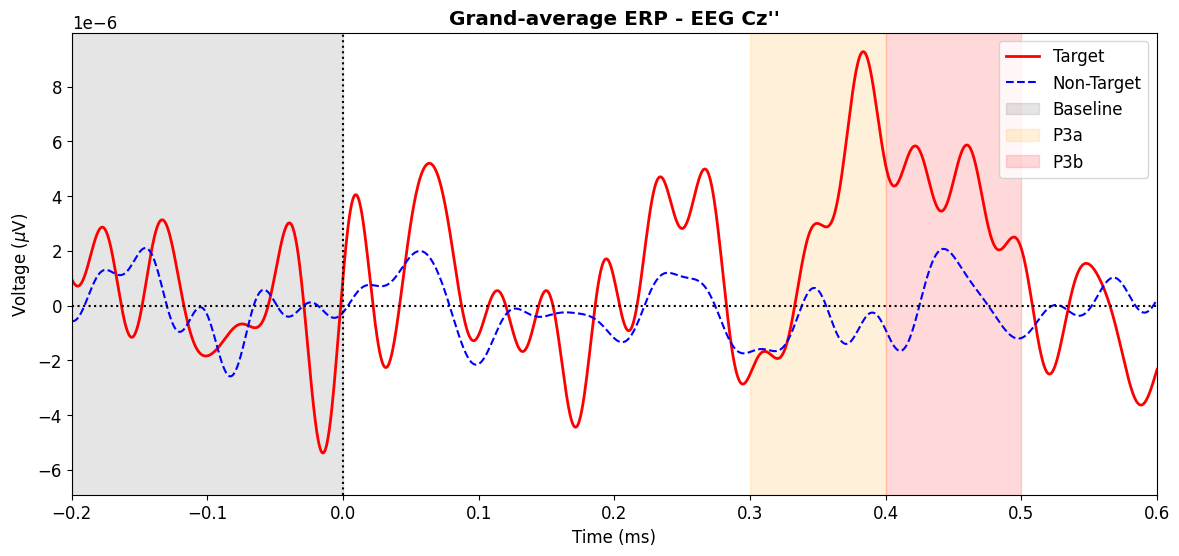

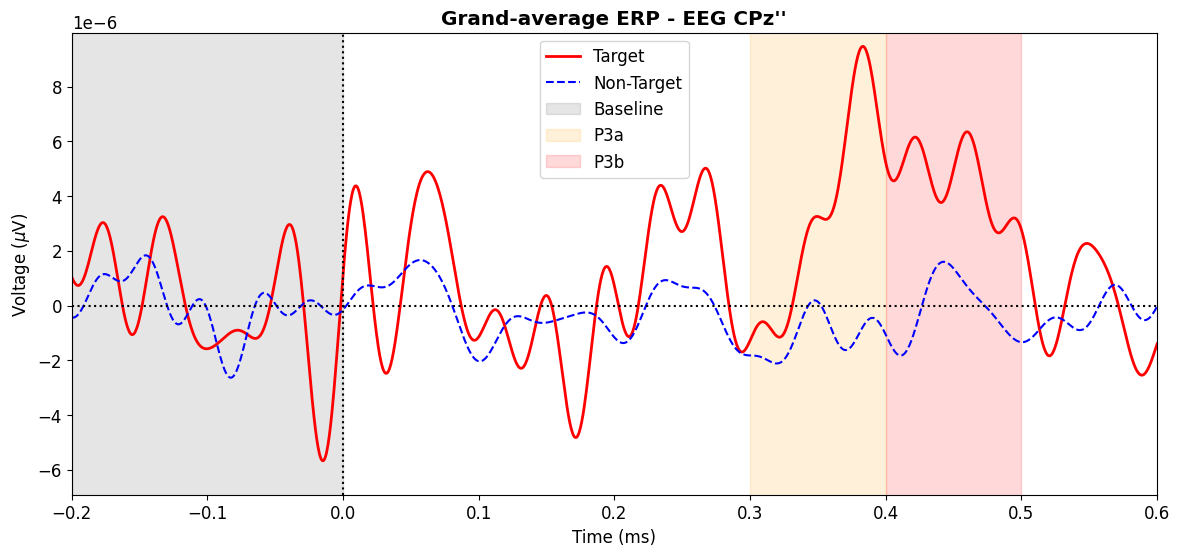

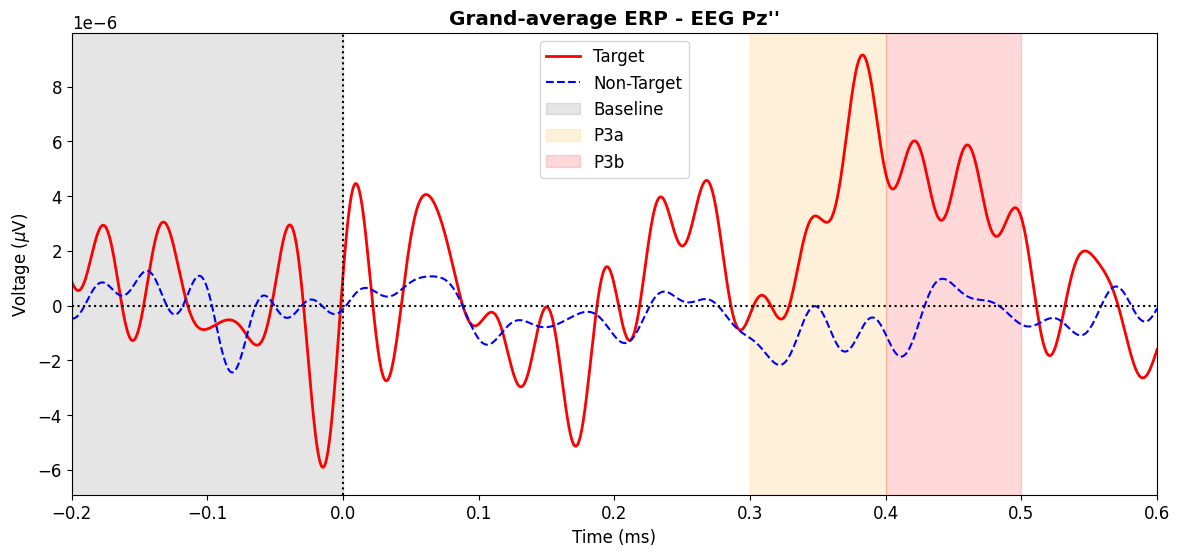

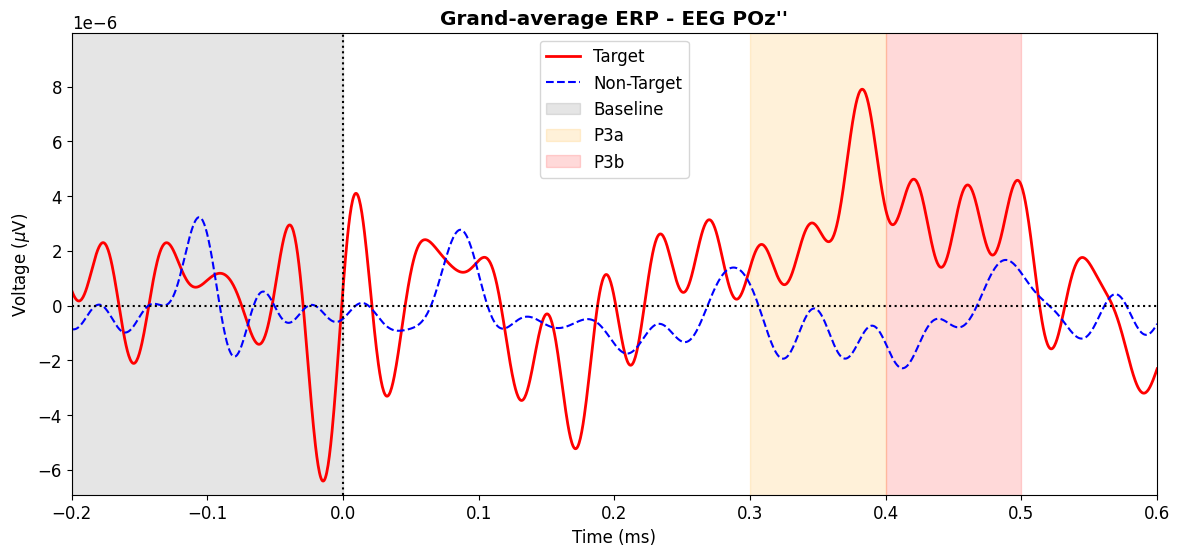

In [493]:
import matplotlib.patches as patches

for c in P3_ch_idx:
    fig, ax = plt.subplots(figsize=(14, 6))
    plt.plot(ERP_times, target_ERP[c], color = 'red', label = 'Target',  linewidth = 2);
    plt.plot(ERP_times, nontarget_ERP[c], 'b--', label = 'Non-Target');
    plt.title(f"Grand-average ERP - {ch[c]}", weight = 'bold')
    plt.xlabel("Time (ms)")
    plt.ylabel("Voltage ($\mu$V)")
    plt.axvline(x = 0, linestyle = ':', color = 'black')
    plt.axhline(y = 0, linestyle = ':', color = 'black')
    plt.xlim([preStim_offset,posStim_offset])
    plt.ylim([np.min(target_ERP[P3_ch_idx]) - 0.5 * 10**(-6),np.max(target_ERP[P3_ch_idx]) + 0.5 * 10**(-6)])
    baseline_region = patches.Rectangle((-0.2, -0.1), 0.2, 0.2, linewidth = 1, edgecolor = 'black', facecolor = 'black', alpha = 0.1, label = 'Baseline')
    ax.add_patch(baseline_region)
    if c in P3_ch_idx:
        '''
        ----- Patches info: -----
        (200, -1) is the bottom-left corner of the rectangle (x, y coordinates). Note the y values in the graph are in microVolts
        0.1 is the width of the rectangle.
        0.2 is the height of the rectangle.
        '''
        P3a_region = patches.Rectangle((0.3, -0.1), 0.1, 0.2, linewidth=1, edgecolor='orange', facecolor='orange', alpha=0.15, label = 'P3a')
        ax.add_patch(P3a_region)
        P3b_region = patches.Rectangle((0.4, -0.1), 0.1, 0.2, linewidth=1, edgecolor='red', facecolor='red', alpha=0.15, label = 'P3b')
        ax.add_patch(P3b_region)
    plt.legend()
    plt.show()

# **Mapping targets to object location**

In [494]:
trial_order_folder = "C:/Users/migue/OneDrive/Ambiente de Trabalho/Tese/AcquisitionProtocols/RealDroneImg_Protocol/Stim_Order_Files/EEG_Sara_001"
subfolders, trialfiles = run_fast_scandir(trial_order_folder, [".xlsx"])

import natsort
sort_trialfiles = natsort.natsorted(trialfiles)

In [495]:
import pandas as pd

centroid_mapped_targets = []
images = []

count = 0

for file in sort_trialfiles:
    sheet = pd.read_excel(file)
    
    for row in sheet.values:
        if row[2] == "Target":
            centroid_mapped_targets.append([baseline_corr_targets[count], row[-1]]) # Mapping rows || Field one comprises the data | Field two comprises the object centroid 
            images.append(row[1]) # row[0] = trial iterator
            count = count + 1

## Visual angle calculation

In [496]:
SCREEN_WIDTH_PX = 1920
SCREEN_HEIGHT_PX = 1080

SCREEN_DIAGONAL_SIZE_INCH = 27

def visual_angle(object_x_px, object_y_px, H_image_width_px, V_image_width_px, screen_width_px, screen_height_px):
    
    # https://www.reddit.com/r/oculus/comments/1dmcsh/default_eye_to_screen_distance/ corresponds to measurement
    #observer_distance_mm = 40 # in mm for the HMD (Oculus Rift)
    OBSERVER_DISTANCE_MM = 1000 # in mm for the C1 computer

    # Width and Height of the screen in mm
    SCREEN_WIDTH_MM = 699
    SCREEN_HEIGHT_MM = 395
 
    # Convert the size of the image in pixels to mm
    H_image_width_mm = (SCREEN_WIDTH_MM * H_image_width_px)/screen_width_px
    V_image_width_mm = (SCREEN_HEIGHT_MM * V_image_width_px)/screen_height_px

    # Visual angle of the image
    H_image_width_deg = np.degrees(2 * (np.arctan(H_image_width_mm / (OBSERVER_DISTANCE_MM * 2))))
    V_image_width_deg = np.degrees(2 * (np.arctan(V_image_width_mm / (OBSERVER_DISTANCE_MM * 2))))

    # How many degrees in the visual field represents one pixel in the images
    H_visual_angle_per_px = H_image_width_deg / H_image_width_px 
    V_visual_angle_per_px = V_image_width_deg / V_image_width_px

    H_object_x_deg = (object_x_px - (H_image_width_px / 2)) * H_visual_angle_per_px
    V_object_y_deg = (object_y_px - (V_image_width_px / 2)) * V_visual_angle_per_px

    return H_object_x_deg, V_object_y_deg

In [497]:
x,y=visual_angle(1344/2, 1134/2, 1344/2, 1134/2, SCREEN_WIDTH_PX, SCREEN_HEIGHT_PX)
print(x,y)

6.974058729692531 5.91970218693015


In [498]:
# This is for the PsycgoPy -> trial -> trialImage -> Layout -> Size[w,h] $
wPx = 1344
hPx = 1134

print(f"Size [{round(wPx * 0.5 / hPx, 3)}, 0.5]") # This mantains the proportion of width and height in the scalling done in PsychoPy

wPx = wPx * 0.5 # px
hPx = hPx * 0.5 # px

# Now we have to define how to devide the visual field for the VR headset
# In the original study had a width of 11.5 x 11.8 degrees and 640 x 640 in pixels. 
# Also, a threshold of +/- 1.2 degrees to classify the images for the LVF and RVF 

#observer_distance_mm = 40
OBSERVER_DISTANCE_MM = 1000

# Inches to mm the screen size
screen_diagonal_size_mm = SCREEN_DIAGONAL_SIZE_INCH * 25.4 

# Angle of the diagonal of the screen
width_height_angle = np.arctan(SCREEN_HEIGHT_PX/SCREEN_WIDTH_PX) # C_oposed/C_adjacent

# Width and Height of the screen in mm
screen_width_mm = 696
screen_height_mm = 395

# Convert the size of the image in pixels to mm
H_image_width_mm = (screen_width_mm * wPx)/SCREEN_WIDTH_PX
V_image_width_mm = (screen_height_mm * hPx)/SCREEN_HEIGHT_PX

# Visual angle of the image
H_image_width_deg = np.degrees(2 * (np.arctan(H_image_width_mm / (OBSERVER_DISTANCE_MM * 2))))
V_image_width_deg = np.degrees(2 * (np.arctan(V_image_width_mm / (OBSERVER_DISTANCE_MM * 2))))

print("\nWidth of the image in degrees: ", round(H_image_width_deg,3))
print("Height of the image in degrees: ", round(V_image_width_deg,3))

# Paper on Eccentricity of the target stimuli and the N2pc performance: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7160023/pdf/nihms-1065363.pdf 

Size [0.593, 0.5]

Width of the image in degrees:  13.889
Height of the image in degrees:  11.839


## Labelling targets according to the centroid location

In [499]:
import re

H_th = 1.2 # Degrees
V_th = 1.2

PYSCHOPY_RESCALLING = 0.5

IM_WIDTH = 1344 * PYSCHOPY_RESCALLING
IM_HEIGHT = 1134 * PYSCHOPY_RESCALLING

labelled_targets = []

for count, (target_EEG, centroid_str) in enumerate(centroid_mapped_targets):

    # Remove unnecessary characters and split by comma
    cleaned_string = centroid_str[2:-2].split(",")  # Removes [' and '] and splits at ','
    # Extract integers after '=' sign
    centroid = [int(s.split("=")[1]) for s in cleaned_string]

    x_VA, y_VA = visual_angle(centroid[0], centroid[1], IM_WIDTH, IM_HEIGHT, SCREEN_WIDTH_PX, SCREEN_HEIGHT_PX)

    if (x_VA > H_th):
        x_stim_type = "RVF"
    elif (x_VA < -H_th):
        x_stim_type = "LVF"
    else:
        x_stim_type = "CVF"

    if(y_VA > V_th):
        y_stim_type = "TVF"
    elif (y_VA < -V_th):
        y_stim_type = "BVF"
    else:
        y_stim_type = "CVF"

    labelled_targets.append([target_EEG, centroid[0], centroid[1], x_VA, y_VA, x_stim_type, y_stim_type])

print(np.shape(labelled_targets))
           

(210, 7)


c:\Users\migue\anaconda3\envs\BCI\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


# **Averaging Contralateral - Ipsilateral component: N2pc (200 - 400 ms)**

## Separating and concatenating classes

In [500]:
left_N2pc_channels = [" P7", " PO7", " P5", " PO5", " P3", " PO3", " O1"]
right_N2pc_channels = [" P8", " PO8", " P6", " PO6", " P4", " PO4", " O2"]

left_N2pc_ch_idx = pick_channels(ch, left_N2pc_channels)
right_N2pc_ch_idx = pick_channels(ch, right_N2pc_channels)

LVF_contralateral = []
LVF_ipsilateral = []
RVF_contralateral = []
RVF_ipsilateral = []
CVF_contralateral = []
CVF_ipsilateral = []

RVF_x_pos = []
LVF_x_pos = []
CVF_x_pos = []

HORIZONTAL_CONDITION_COL = 5
DATA_COL = 0

for trial in labelled_targets:
    if(trial[HORIZONTAL_CONDITION_COL] == "RVF"):
        RVF_contralateral.append(trial[DATA_COL][left_N2pc_ch_idx,:])
        RVF_ipsilateral.append(trial[DATA_COL][right_N2pc_ch_idx,:])
        RVF_x_pos.append(trial[1])
    elif(trial[HORIZONTAL_CONDITION_COL] == "LVF"):
        LVF_contralateral.append(trial[DATA_COL][right_N2pc_ch_idx,:])
        LVF_ipsilateral.append(trial[DATA_COL][left_N2pc_ch_idx,:])
        LVF_x_pos.append(trial[1])
    elif(trial[HORIZONTAL_CONDITION_COL] == "CVF"):
        CVF_contralateral.append(trial[DATA_COL][right_N2pc_ch_idx,:])
        CVF_ipsilateral.append(trial[DATA_COL][left_N2pc_ch_idx,:])
        CVF_x_pos.append(trial[1])


In [501]:
print("RVF Contralateral trial number:", np.shape(RVF_contralateral))
print("RVF Ipsilateral trial number:", np.shape(RVF_ipsilateral))
print("LVF Contralateral trial number:", np.shape(LVF_contralateral))
print("LVF Ipsilateral trial number:", np.shape(LVF_ipsilateral))
print("CVF Contralateral trial number:", np.shape(CVF_contralateral))
print("CVF Ipsilateral trial number:", np.shape(CVF_ipsilateral))

RVF Contralateral trial number: (70, 7, 1640)
RVF Ipsilateral trial number: (70, 7, 1640)
LVF Contralateral trial number: (70, 7, 1640)
LVF Ipsilateral trial number: (70, 7, 1640)
CVF Contralateral trial number: (70, 7, 1640)
CVF Ipsilateral trial number: (70, 7, 1640)


## Grand-Average

In [502]:
RVF_aver_contralateral = np.mean(RVF_contralateral, axis = 0)
RVF_aver_ipsilateral = np.mean(RVF_ipsilateral, axis = 0)
LVF_aver_contralateral = np.mean(LVF_contralateral, axis = 0)
LVF_aver_ipsilateral = np.mean(LVF_ipsilateral, axis = 0)

aver_cont = (RVF_aver_contralateral + LVF_aver_contralateral)/2
aver_ipsi = (RVF_aver_ipsilateral + LVF_aver_ipsilateral)/2

## Plot

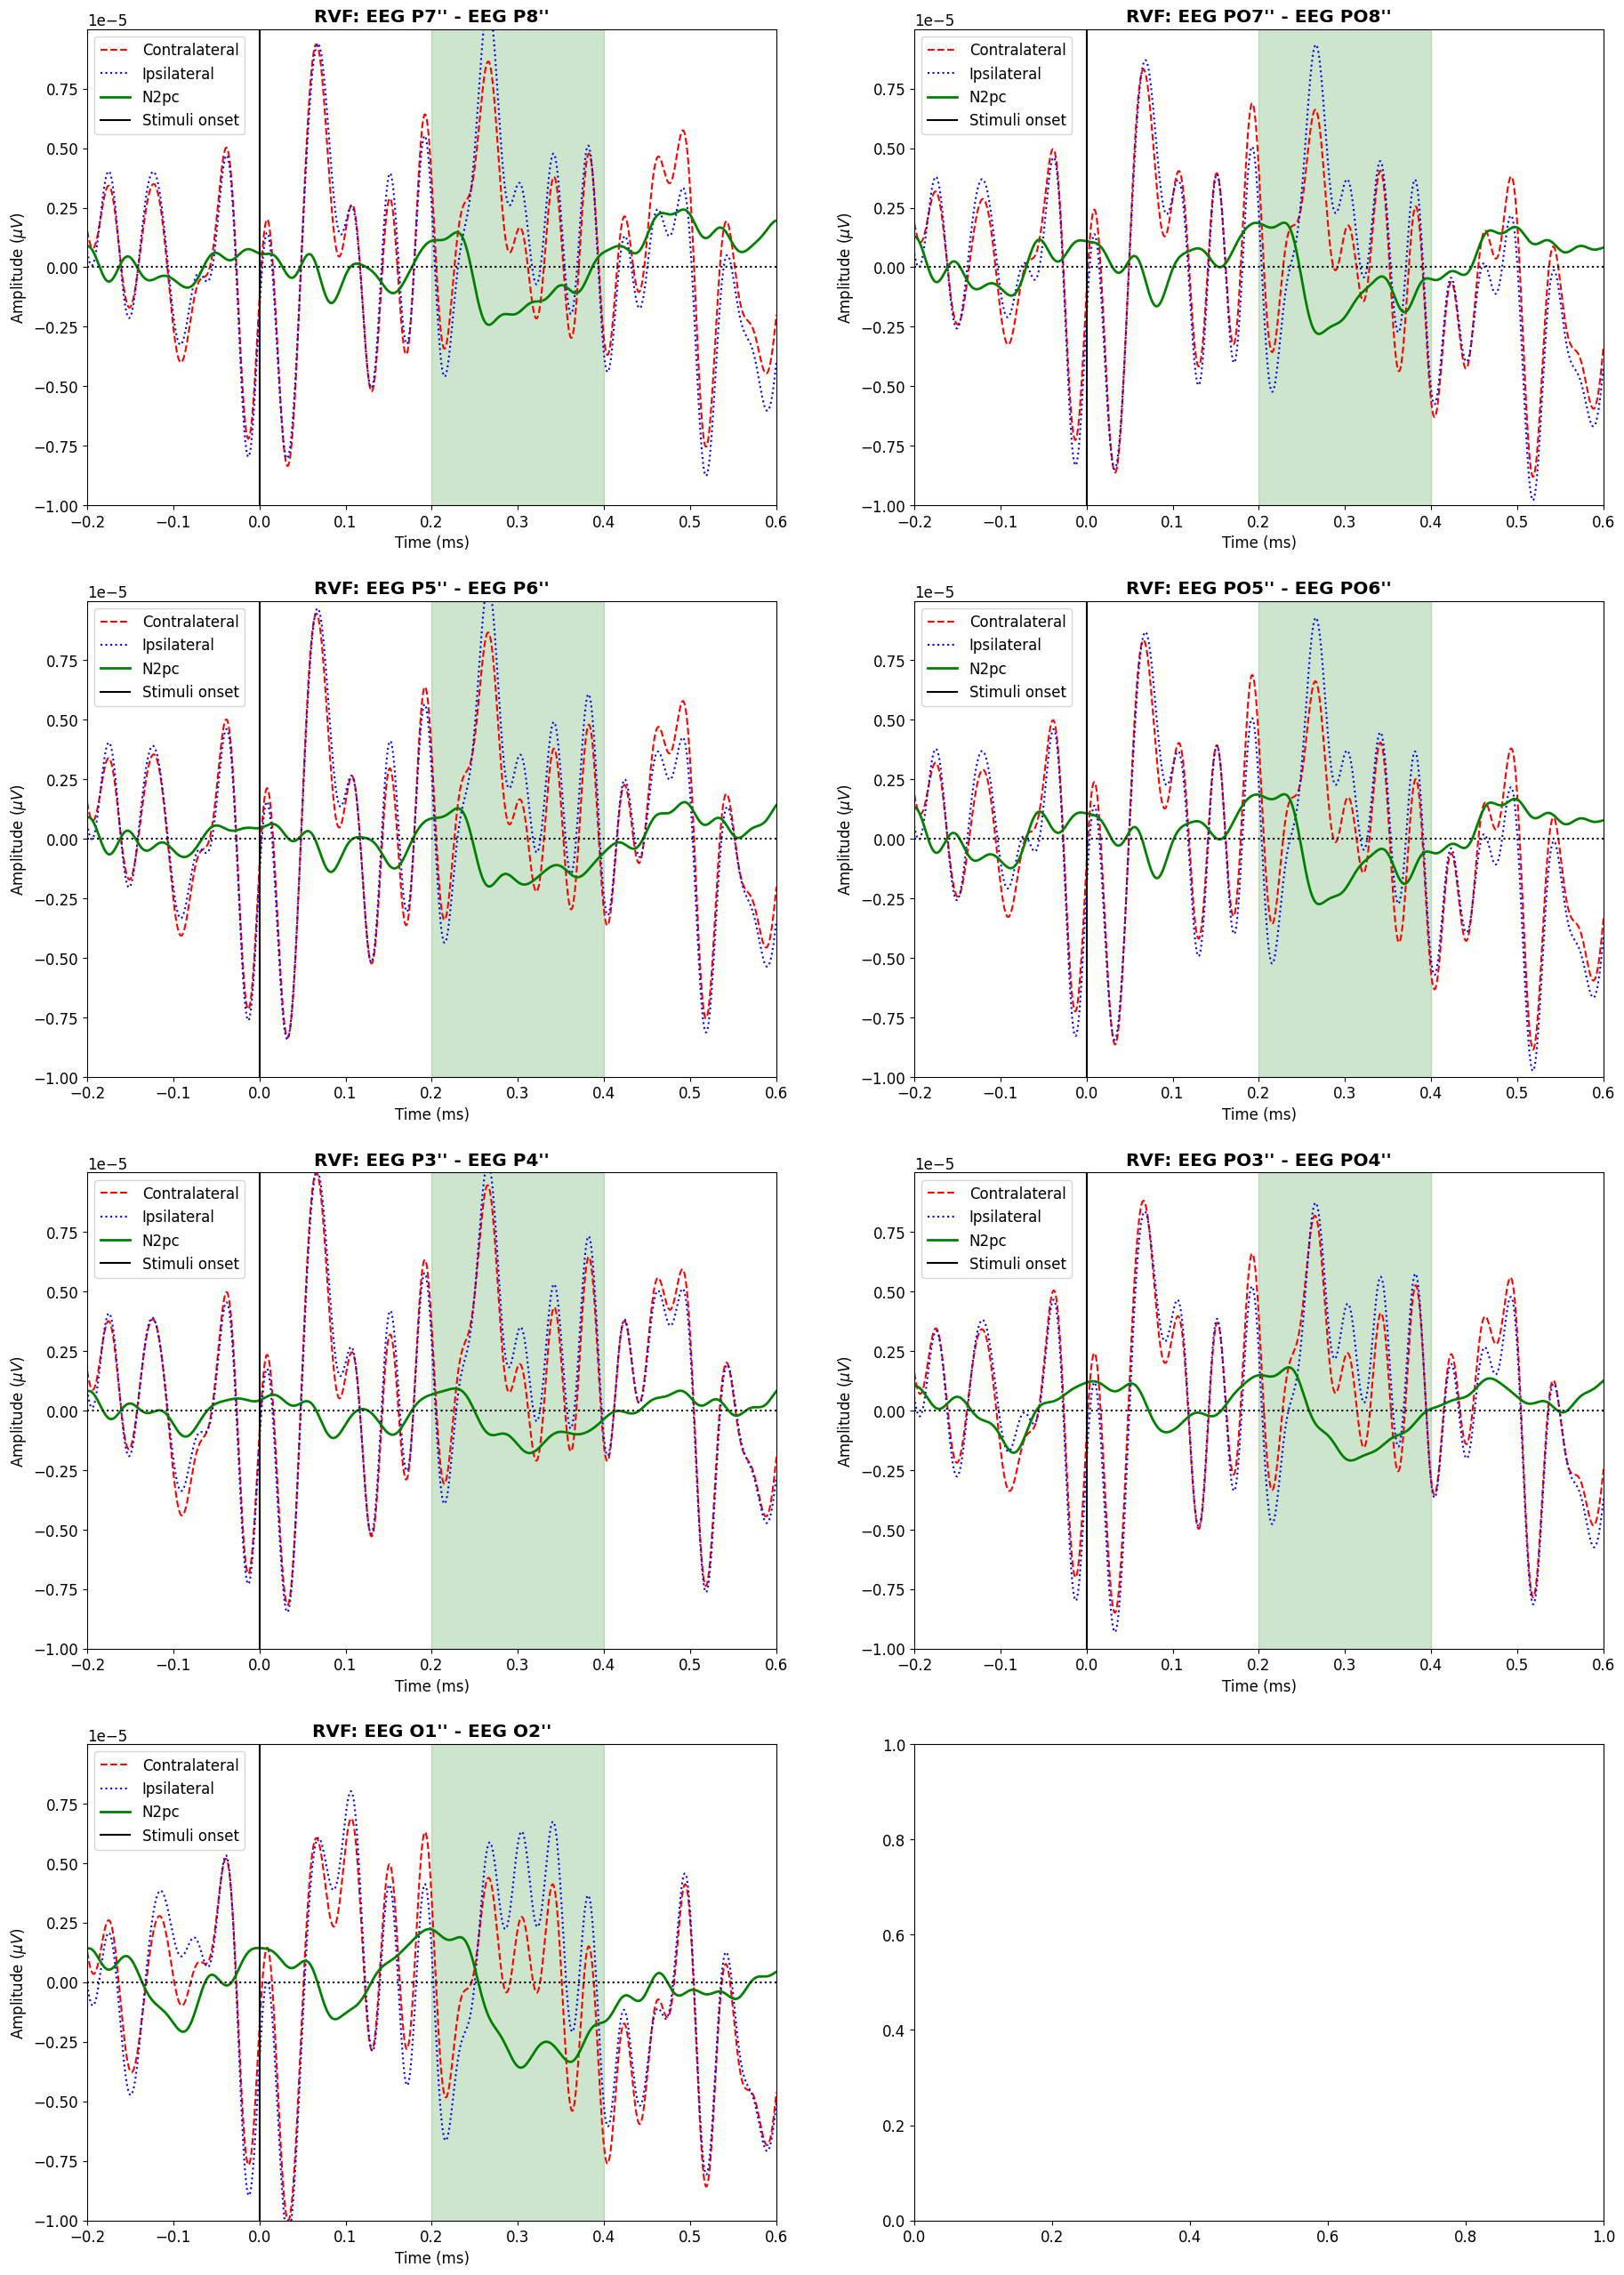

In [503]:
fig, ax = plt.subplots(figsize=(22, 32), nrows=4, ncols=2)

pos = [[0, 0], [0, 1], [1, 0], [1,1], [2,0], [2,1], [3,0]]

for i in range(len(left_N2pc_ch_idx)):
    ax[pos[i][0],pos[i][1]].plot(ERP_times, RVF_aver_contralateral[i],'r--', label = 'Contralateral')
    ax[pos[i][0],pos[i][1]].plot(ERP_times, RVF_aver_ipsilateral[i],'b:', label = 'Ipsilateral')
    ax[pos[i][0],pos[i][1]].plot(ERP_times, RVF_aver_contralateral[i] - RVF_aver_ipsilateral[i],'g', label = 'N2pc', linewidth = 2)
    ax[pos[i][0],pos[i][1]].axvline(x=0, color='k', label = 'Stimuli onset')
    ax[pos[i][0],pos[i][1]].axhline(y=0, color='k', linestyle='dotted')
    ax[pos[i][0],pos[i][1]].set_xlim([np.min(ERP_times),np.max(ERP_times)])
    ax[pos[i][0],pos[i][1]].set_ylim([np.min(RVF_aver_contralateral),np.max(RVF_aver_contralateral)])

    N2pc_region = patches.Rectangle((0.2, -0.1), 0.2, 0.2, linewidth=1, edgecolor='g', facecolor='g', alpha=0.2)
    # - `(200, -1)` is the bottom-left corner of the rectangle (x, y coordinates). Note the y values in the graph are in microVolts
    # - `200` is the width of the rectangle.
    # - `2` is the height of the rectangle.

    ax[pos[i][0],pos[i][1]].add_patch(N2pc_region)

    ax[pos[i][0],pos[i][1]].set_title(f"RVF: {ch[left_N2pc_ch_idx[i]]} - {ch[right_N2pc_ch_idx[i]]}", fontweight = 'bold')
    ax[pos[i][0],pos[i][1]].set_xlabel('Time (ms)')
    ax[pos[i][0],pos[i][1]].set_ylabel('Amplitude ($\mu V$)')
    ax[pos[i][0],pos[i][1]].legend(loc='upper left')

    #ax[pos[i][0],pos[i][1]].invert_yaxis()

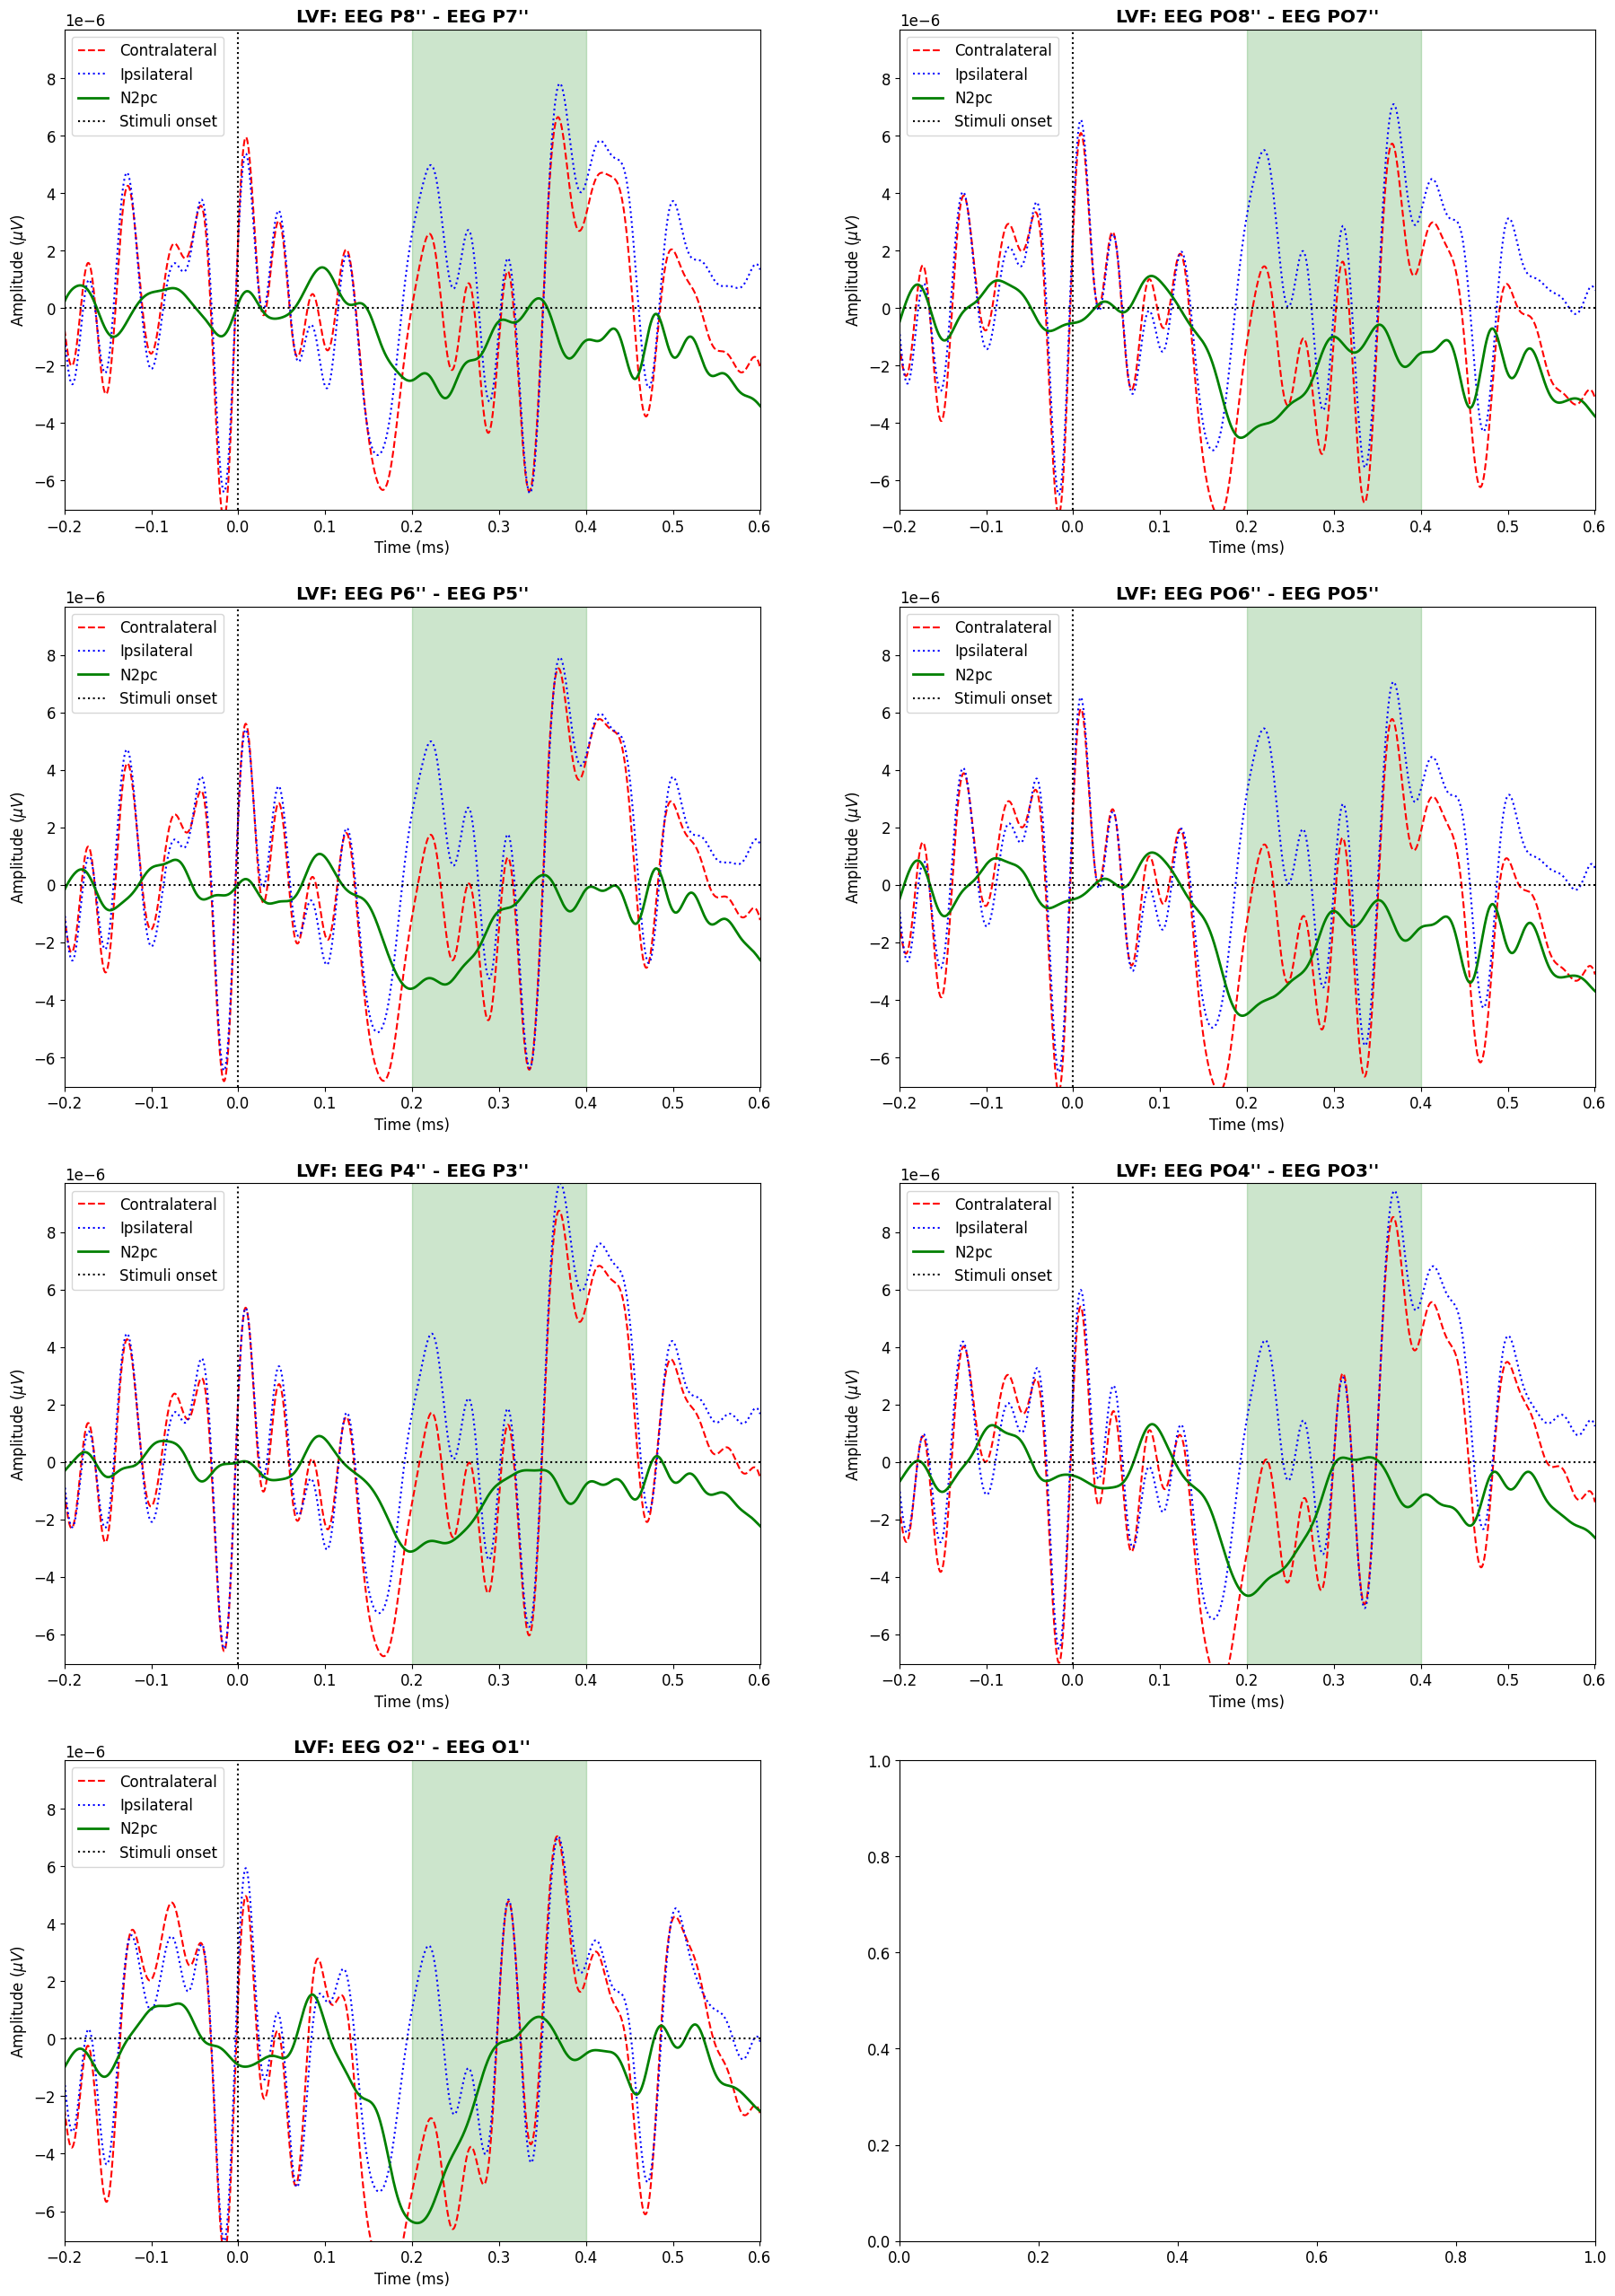

In [504]:
fig, ax = plt.subplots(figsize=(22, 32), nrows=4, ncols=2)

for i in range(len(left_N2pc_ch_idx)):

    ax[pos[i][0],pos[i][1]].plot(ERP_times, LVF_aver_contralateral[i],'r--', label = 'Contralateral')
    ax[pos[i][0],pos[i][1]].plot(ERP_times, LVF_aver_ipsilateral[i],'b:', label = 'Ipsilateral')
    ax[pos[i][0],pos[i][1]].plot(ERP_times, LVF_aver_contralateral[i] - LVF_aver_ipsilateral[i],'g', label = 'N2pc', linewidth = 2)
    ax[pos[i][0],pos[i][1]].axvline(x=0, color='k', linestyle='dotted', label = 'Stimuli onset')
    ax[pos[i][0],pos[i][1]].axhline(y=0, color='k', linestyle='dotted')

    ax[pos[i][0],pos[i][1]].set_xlim([np.min(ERP_times),np.max(ERP_times)])
    ax[pos[i][0],pos[i][1]].set_ylim([np.min(LVF_aver_ipsilateral),np.max(LVF_aver_ipsilateral)])

    N2pc_region = patches.Rectangle((0.2, -0.1), 0.2, 0.2, linewidth=1, edgecolor='g', facecolor='g', alpha=0.2)
    # - `(200, -1)` is the bottom-left corner of the rectangle (x, y coordinates). Note the y values in the graph are in microVolts
    # - `200` is the width of the rectangle.
    # - `2` is the height of the rectangle.

    ax[pos[i][0],pos[i][1]].add_patch(N2pc_region)

    ax[pos[i][0],pos[i][1]].set_title(f"LVF: {ch[right_N2pc_ch_idx[i]]} - {ch[left_N2pc_ch_idx[i]]}", fontweight = 'bold')
    ax[pos[i][0],pos[i][1]].set_xlabel('Time (ms)')
    ax[pos[i][0],pos[i][1]].set_ylabel('Amplitude ($\mu V$)')
    ax[pos[i][0],pos[i][1]].legend(loc='upper left')

    #ax[pos[i][0],pos[i][1]].invert_yaxis()

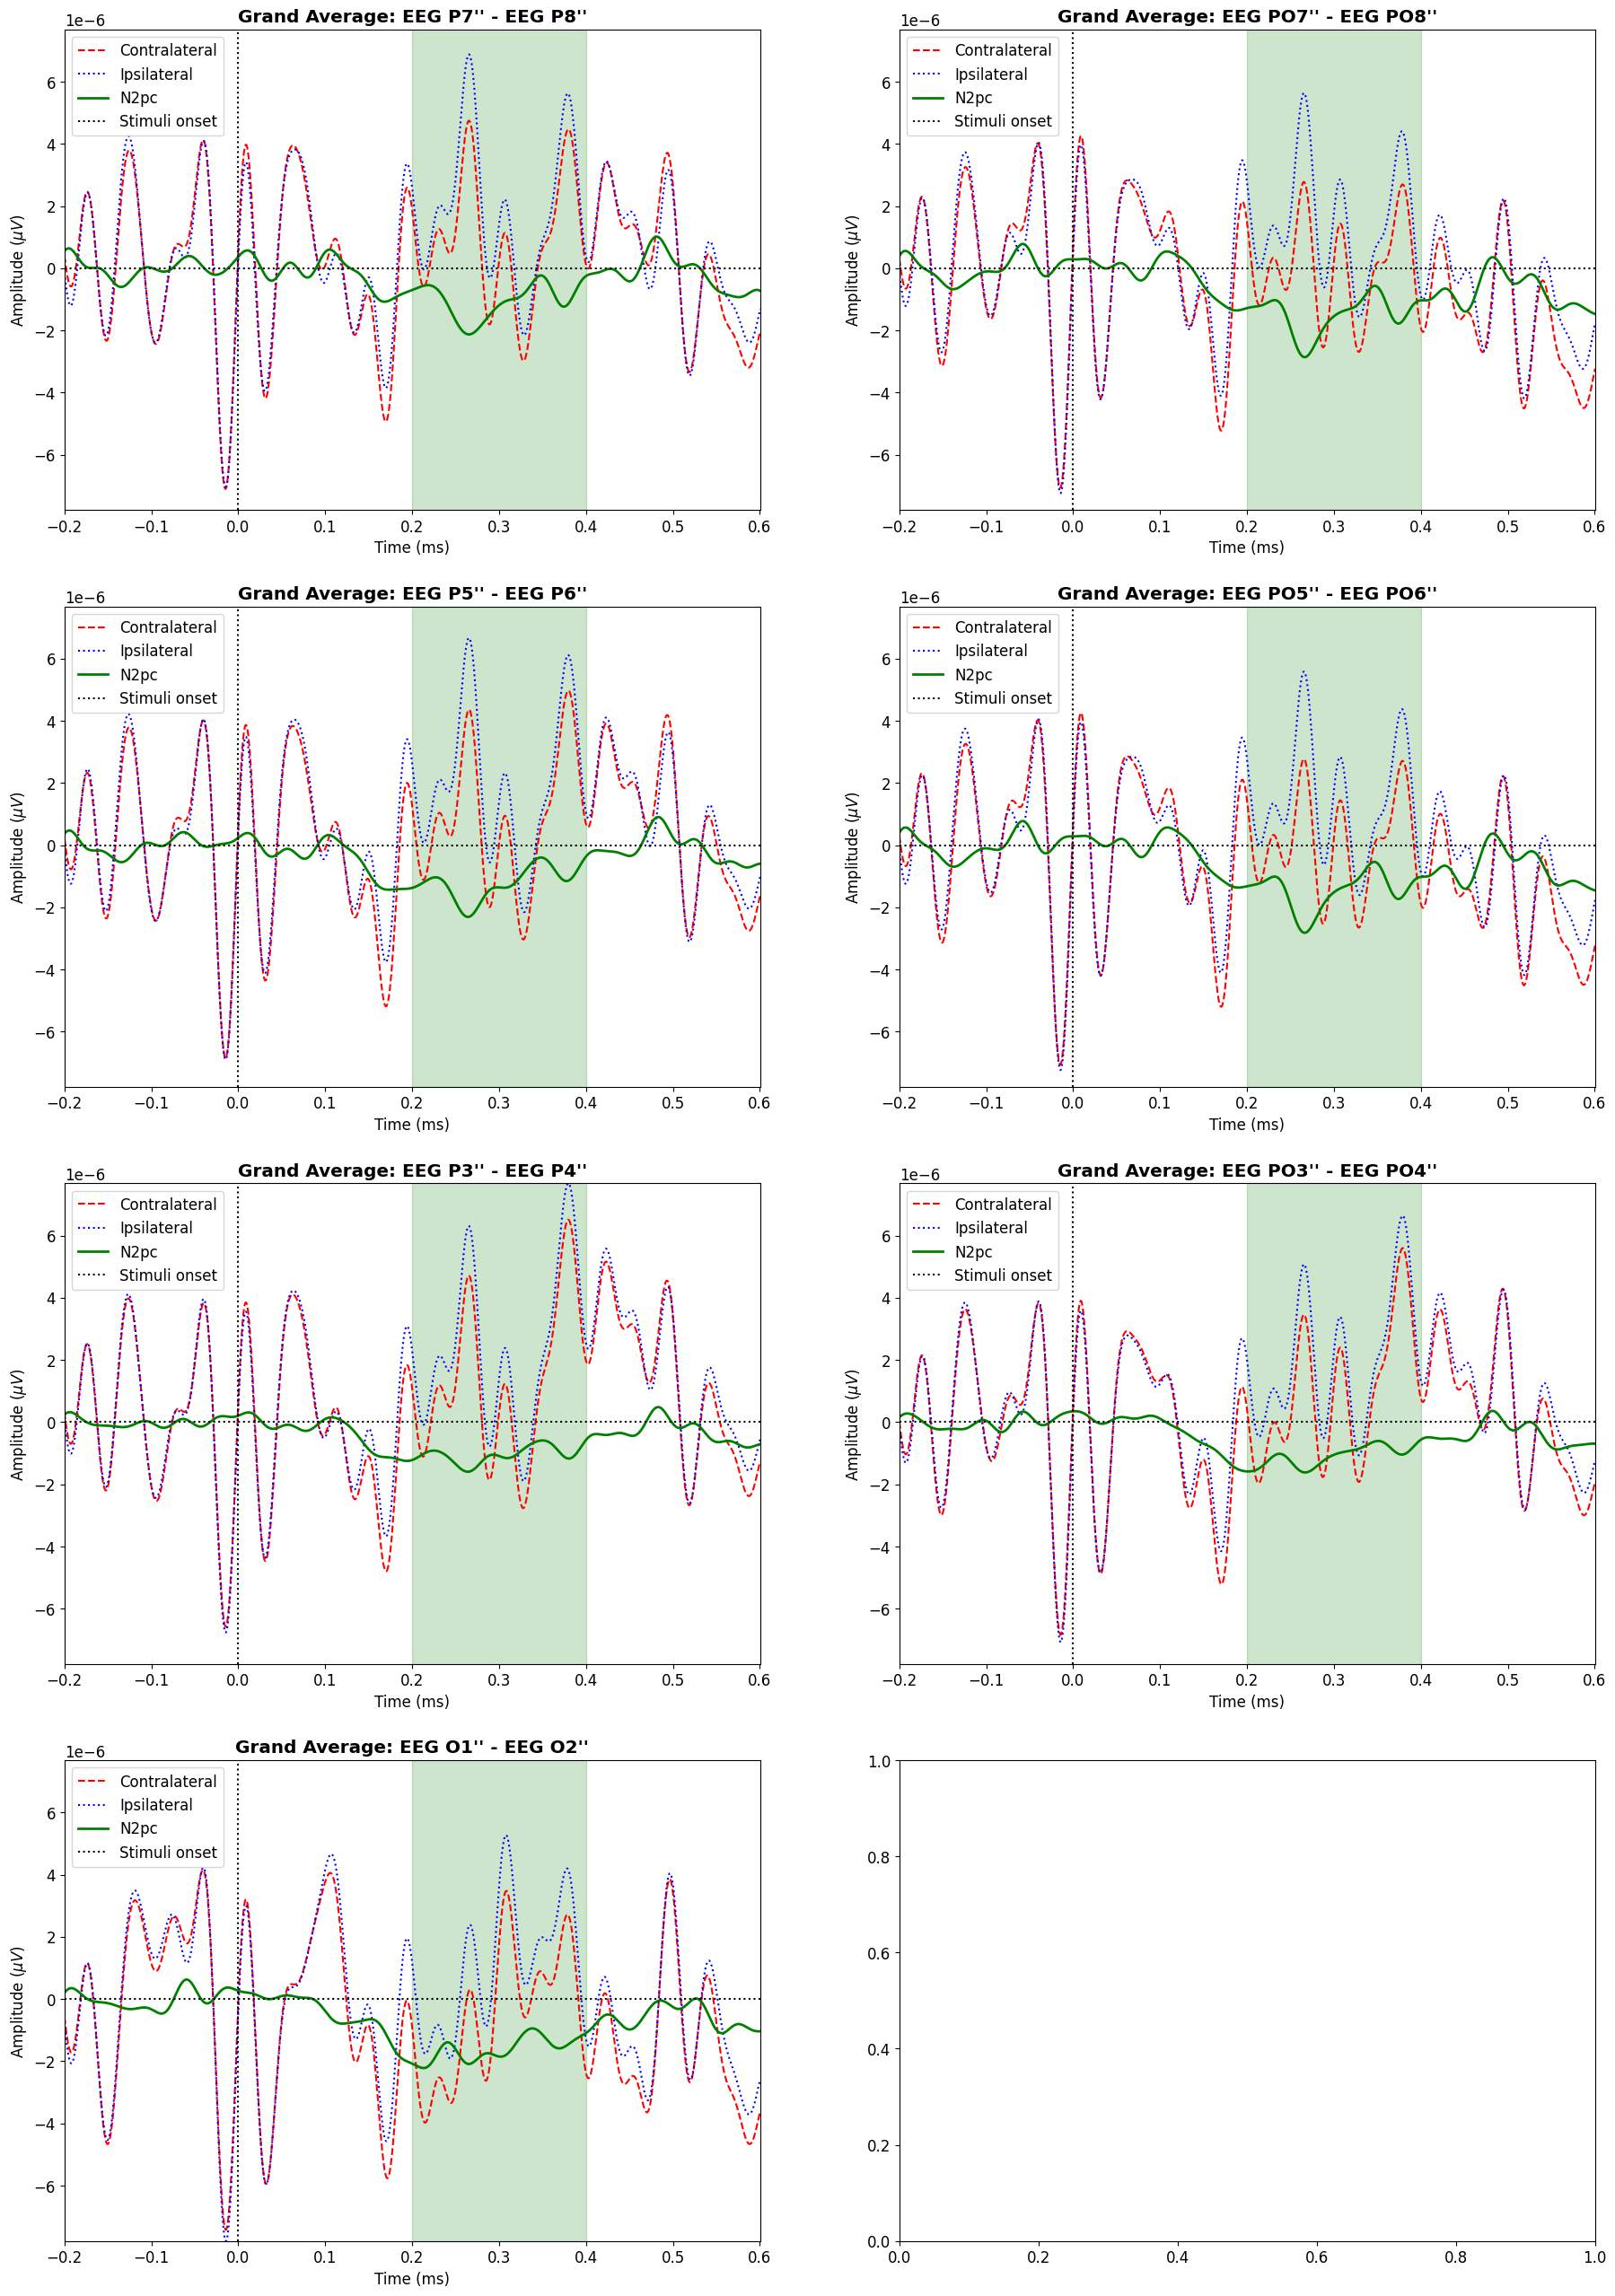

In [505]:
fig, ax = plt.subplots(figsize=(22, 32), nrows=4, ncols=2)

for i in range(len(left_N2pc_ch_idx)):

    ax[pos[i][0],pos[i][1]].plot(ERP_times, aver_cont[i],'r--', label = 'Contralateral')
    ax[pos[i][0],pos[i][1]].plot(ERP_times, aver_ipsi[i],'b:', label = 'Ipsilateral')
    ax[pos[i][0],pos[i][1]].plot(ERP_times, aver_cont[i] - aver_ipsi[i],'g', label = 'N2pc', linewidth = 2)
    ax[pos[i][0],pos[i][1]].axvline(x=0, color='k', linestyle='dotted', label = 'Stimuli onset')
    ax[pos[i][0],pos[i][1]].axhline(y=0, color='k', linestyle='dotted')

    ax[pos[i][0],pos[i][1]].set_xlim([np.min(ERP_times), np.max(ERP_times)])
    ax[pos[i][0],pos[i][1]].set_ylim([np.min(aver_ipsi), np.max(aver_ipsi)])

    N2pc_region = patches.Rectangle((0.2, -0.1), 0.2, 0.2, linewidth=1, edgecolor='g', facecolor='g', alpha=0.2)    # - `(200, -1)` is the bottom-left corner of the rectangle (x, y coordinates). Note the y values in the graph are in microVolts
    # - `200` is the width of the rectangle.
    # - `2` is the height of the rectangle.

    ax[pos[i][0],pos[i][1]].add_patch(N2pc_region)

    ax[pos[i][0],pos[i][1]].set_title(f"Grand Average: {ch[left_N2pc_ch_idx[i]]} - {ch[right_N2pc_ch_idx[i]]}", fontweight = 'bold')
    ax[pos[i][0],pos[i][1]].set_xlabel('Time (ms)')
    ax[pos[i][0],pos[i][1]].set_ylabel('Amplitude ($\mu V$)')
    ax[pos[i][0],pos[i][1]].legend(loc='upper left')

    #ax[pos[i][0],pos[i][1]].invert_yaxis()

## Calculate the single-trial N2pc component

In [506]:
from scipy.signal import resample

# Isolating the datapoints related to the N2pc time window 

n_trials, n_channels, _ = np.shape(RVF_contralateral)

ts = 0.2
te = 0.4

idx_s = np.argmin(np.abs(ERP_times - ts))
idx_e = np.argmin(np.abs(ERP_times - te))

# Resampling the resulting time window (Prevents overfitting)

RESAMPLE_FREQ = 64 # Hz
N_DATAPOINTS_ORIG_FREQ = len(ERP_times[idx_s:idx_e+1])
N_DATAPOINTS_RESA_FREQ = int(np.ceil((N_DATAPOINTS_ORIG_FREQ * RESAMPLE_FREQ)/fs))

LVF = [] # Class label = 0
RVF = [] # Class label = 1

featVectLVF = []
featVectRVF = []

NN_featVectRVF = []
NN_featVectLVF = []

for trial in range(n_trials):

    RVF = resample(RVF_contralateral[trial][:,idx_s:idx_e+1] - RVF_ipsilateral[trial][:,idx_s:idx_e+1], N_DATAPOINTS_RESA_FREQ, axis = -1)
    LVF = resample(LVF_contralateral[trial][:,idx_s:idx_e+1] - LVF_ipsilateral[trial][:,idx_s:idx_e+1], N_DATAPOINTS_RESA_FREQ, axis = -1)
    
    for c in range(1, n_channels):

        if (c == 1):
            auxRVF = np.hstack((RVF[c-1,:],RVF[c,:]))
            auxLVF = np.hstack((LVF[c-1,:],LVF[c,:]))
        else:
            auxRVF = np.hstack((auxRVF,RVF[c,:]))
            auxLVF = np.hstack((auxLVF,LVF[c,:]))
    
    '''
    if(trial >= 0 and trial <= 30):
        plt.plot(LVF[0], "b:", label = "LVF")
        plt.plot(RVF[0], "r", label = "RVF")
        plt.legend()
        plt.show()
    '''

    featVectRVF.append(np.hstack((auxRVF, 1)))
    featVectLVF.append(np.hstack((auxLVF, 0)))

    NN_featVectRVF.append(np.hstack((auxRVF, RVF_x_pos[trial])))
    NN_featVectLVF.append(np.hstack((auxLVF, LVF_x_pos[trial])))

print(np.shape(featVectRVF))
print(np.shape(featVectLVF))

(70, 92)
(70, 92)


# **Classification**

## Train/Test Split and concatenate feature vectors for all channel differences

In [507]:
import random

PERCENT_TRAIN = 0.75

n_train = int(np.ceil(n_trials * PERCENT_TRAIN))

train_featVect = np.vstack((featVectRVF[:n_train], featVectLVF[:n_train]))
test_featVect = np.vstack((featVectRVF[n_train:], featVectLVF[n_train:]))

random.seed(42)
np.random.shuffle(train_featVect)
random.seed(42)
np.random.shuffle(test_featVect)


In [508]:
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score

kfold = 10

# SVM
kernel = 'sigmoid'
clf = SVC(kernel=kernel, probability=True)
scores = cross_val_score(clf, train_featVect[:, :-1], train_featVect[:, -1], cv=kfold)
clf.fit(train_featVect[:, :-1], train_featVect[:, -1])
pred = clf.predict(test_featVect[:, 0:-1])
print("------------- SVM -------------")
print("AUC: ", round(roc_auc_score(test_featVect[:, -1], clf.predict_proba(test_featVect[:, 0:-1])[:,1]),2))
print(f"Cross validation mean score: {round(scores.mean(),2)} +/- {round(scores.std(),2)}")
print("Accuracy: ", round(accuracy_score(test_featVect[:,-1], pred),2))

# LDA
clf = LDA()
scores = cross_val_score(clf, train_featVect[:, :-1], train_featVect[:, -1], cv=kfold)
clf.fit(train_featVect[:, :-1], train_featVect[:, -1])
pred = clf.predict(test_featVect[:, 0:-1])
print("\n------------- LDA -------------")
print("AUC: ", round(roc_auc_score(test_featVect[:, -1], clf.predict_proba(test_featVect[:, 0:-1])[:,1]),2))
print(f"Cross validation mean score: {round(scores.mean(),2)} +/- {round(scores.std(),2)}")
print("Accuracy: ", round(accuracy_score(test_featVect[:,-1], pred),2))

# Random Forest
clf = RandomForestClassifier()  # Create an instance of Random Forest classifier
scores = cross_val_score(clf, train_featVect[:, :-1], train_featVect[:, -1], cv=kfold)
clf.fit(train_featVect[:, :-1], train_featVect[:, -1])
pred = clf.predict(test_featVect[:, 0:-1])
print("\n------------- Random Forest -------------")
print("AUC: ", round(roc_auc_score(test_featVect[:, -1], clf.predict_proba(test_featVect[:, 0:-1])[:,1]),2))
print(f"Cross validation mean score: {round(scores.mean(),2)} +/- {round(scores.std(),2)}")
print("Accuracy: ", round(accuracy_score(test_featVect[:,-1], pred),2))

# XGBoost
clf = xgb.XGBClassifier()  # Create an instance of XGBoost classifier
scores = cross_val_score(clf, train_featVect[:, :-1], train_featVect[:, -1], cv=kfold)
clf.fit(train_featVect[:, :-1], train_featVect[:, -1])
pred = clf.predict(test_featVect[:, 0:-1])
print("\n------------- XGBoost -------------")
print("AUC: ", round(roc_auc_score(test_featVect[:, -1], clf.predict_proba(test_featVect[:, 0:-1])[:,1]),2))
print(f"Cross validation mean score: {round(scores.mean(),2)} +/- {round(scores.std(),2)}")
print("Accuracy: ", round(accuracy_score(test_featVect[:,-1], pred),2))

# Adaboost
clf = AdaBoostClassifier()  # Create an instance of AdaBoost classifier
scores = cross_val_score(clf, train_featVect[:, :-1], train_featVect[:, -1], cv=kfold)
clf.fit(train_featVect[:, :-1], train_featVect[:, -1])
pred = clf.predict(test_featVect[:, 0:-1])
print("\n------------- AdaBoost -------------")
print("AUC: ", round(roc_auc_score(test_featVect[:, -1], clf.predict_proba(test_featVect[:, 0:-1])[:,1]),2)) # [:,1] is related to the column of probability predictions of the second class (1). [:,0] would be the first (0)
print(f"Cross validation mean score: {round(scores.mean(),2)} +/- {round(scores.std(),2)}")
print("Accuracy: ", round(accuracy_score(test_featVect[:,-1], pred),2))



------------- SVM -------------
AUC:  0.96
Cross validation mean score: 0.8 +/- 0.09
Accuracy:  0.85

------------- LDA -------------
AUC:  0.8
Cross validation mean score: 0.63 +/- 0.1
Accuracy:  0.74

------------- Random Forest -------------
AUC:  0.9
Cross validation mean score: 0.79 +/- 0.13
Accuracy:  0.76

------------- XGBoost -------------
AUC:  0.9
Cross validation mean score: 0.83 +/- 0.14
Accuracy:  0.79

------------- AdaBoost -------------
AUC:  0.94
Cross validation mean score: 0.79 +/- 0.12
Accuracy:  0.82


# **Deep Learning - Estimating the target object along the x axis in the images**

In [509]:
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## NN model

In [528]:
train_featVect = np.vstack((NN_featVectRVF[:n_train], NN_featVectLVF[:n_train]))
test_featVect = np.vstack((NN_featVectRVF[n_train:], NN_featVectLVF[n_train:]))

torch.manual_seed(42)

NUM_FEATURES = np.size(NN_featVectRVF,1)-1 # Last row contains the x positions ()

class N2pcModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.Sigmoid(), 
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Sigmoid(), 
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

## Training model

In [529]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
dl_epochs = 20000
    
# Initializing model

x_pos_model = N2pcModel(input_features=NUM_FEATURES, 
                output_features=1, 
                hidden_units=16).to(device)

loss_fn = nn.SmoothL1Loss()
optimizer = torch.optim.Adamax(x_pos_model.parameters(), 
                        lr=0.005) 

# Shuffle

np.random.seed(42)
np.random.shuffle(train_featVect)
np.random.seed(42)
np.random.shuffle(test_featVect)

# Tensor convertion
tn_train_feat = torch.tensor(np.array(train_featVect[:,0:-1])).type(torch.float32)
tn_train_lbl = torch.tensor(np.array(train_featVect[:,-1])).type(torch.float32)

tn_test_feat = torch.tensor(np.array(test_featVect[:,0:-1])).type(torch.float32)
tn_test_lbl = torch.tensor(np.array(test_featVect[:,-1])).type(torch.float32)

# Feature wise normalization of feature vector
n_entries, n_feat = tn_train_feat.size()

for j in range(n_entries):

    mean = tn_train_feat[j,:].mean(dim=0)
    std = tn_train_feat[j,:].std(dim=0)
    tn_train_feat[j,:] = (tn_train_feat[j,:] - mean) / std

n_entries, n_feat = tn_test_feat.size()

for u in range(n_entries):

    mean = tn_test_feat[u,:].mean(dim=0)
    std = tn_test_feat[u,:].std(dim=0)
    tn_test_feat[u,:] = (tn_test_feat[u,:] - mean) / std

training_losses = []
testing_losses = []

for dl_epoch in range(dl_epochs):
    ### Training
    x_pos_model.train()

    # 1. Forward pass
    x_pos_ = x_pos_model(tn_train_feat)

    # 2. Calculate loss
    train_loss = loss_fn(torch.squeeze(x_pos_), tn_train_lbl) 
    training_losses.append(train_loss.detach().numpy())
  
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    train_loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    x_pos_model.eval()
    with torch.inference_mode():
      # 1. Forward pass
      output = x_pos_model(tn_test_feat)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(torch.squeeze(output), tn_test_lbl)
      testing_losses.append(test_loss.detach().numpy())

    # Print out what's happening
    if (dl_epoch + 1) % 2000 == 0:
        print(f"Epoch: {dl_epoch + 1} | Training Loss: {train_loss:.5f}, | Testing Loss: {test_loss:.5f}")  

# ------------------------------------ Test ------------------------------------

# 1. Set the model in evaluation mode

x_pos_model.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  x_preds = x_pos_model(tn_test_feat)
  
x_preds = x_preds.numpy()
real_x = tn_test_lbl.numpy()

Epoch: 2000 | Training Loss: 212.60925, | Testing Loss: 227.95789
Epoch: 4000 | Training Loss: 135.69081, | Testing Loss: 187.35803
Epoch: 6000 | Training Loss: 62.91024, | Testing Loss: 128.80026
Epoch: 8000 | Training Loss: 31.56048, | Testing Loss: 108.77228
Epoch: 10000 | Training Loss: 6.22116, | Testing Loss: 103.56796
Epoch: 12000 | Training Loss: 2.97357, | Testing Loss: 107.90131
Epoch: 14000 | Training Loss: 0.72181, | Testing Loss: 105.82817
Epoch: 16000 | Training Loss: 0.29053, | Testing Loss: 107.44810
Epoch: 18000 | Training Loss: 0.04146, | Testing Loss: 108.98933
Epoch: 20000 | Training Loss: 0.04891, | Testing Loss: 109.38173


## Ploting predictions against the real values of the object's position alongisde the x-axis

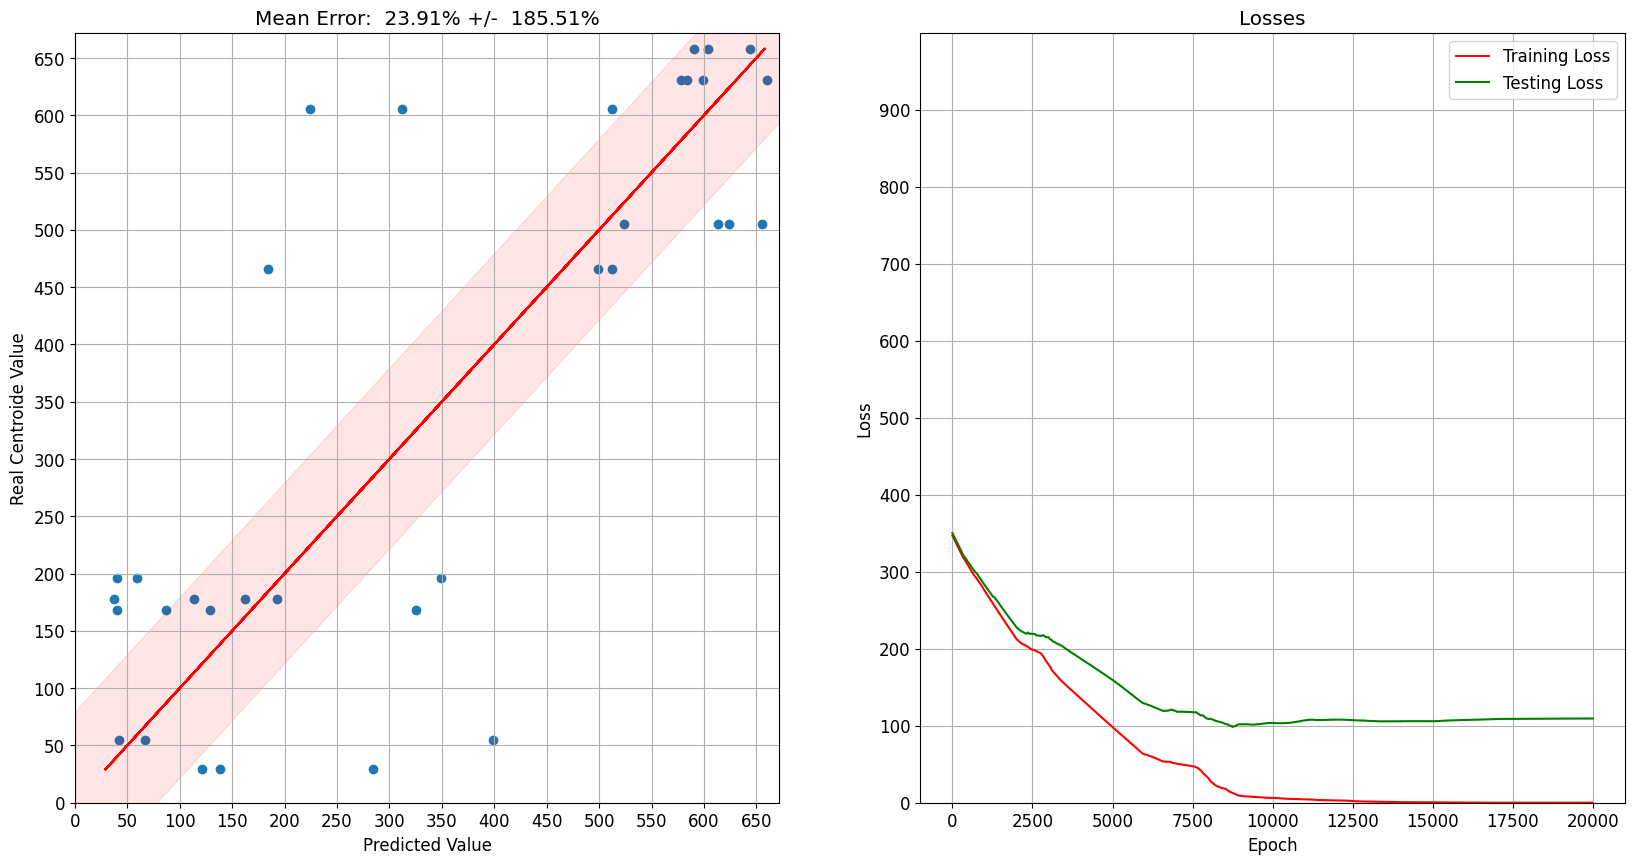

In [530]:
import math

obj_region = (672 * 3)/18.1

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

x_losses = np.linspace(0, dl_epochs, dl_epochs)

plt.rcParams.update({'font.size': 12})

ax = axs[0]

x_preds = x_preds.reshape(len(x_preds),)
rel_error = (np.abs(x_preds - real_x)/real_x)*100

ax.scatter(x_preds, real_x);
ax.set(xlabel='Predicted Value', 
    xticks=np.arange(0, 672, step = 50),
    xlim=(0,672),
    ylabel='Real Centroide Value',
    yticks=np.arange(0, 672, step = 50),
    ylim=(0,672),
    title=(f"Mean Error: {np.median(rel_error): .2f}% +/- {np.std(rel_error): .2f}%"));
ax.grid(True)

ax.plot(real_x, real_x, 'r') # Line plot

diag_rect = patches.Rectangle(
    (min(real_x) - 50, (min(real_x))-(obj_region/2)/math.cos(math.radians(45)) - 50), 
                                max(real_x) + 400, obj_region, 
                                linewidth=1, edgecolor='r', facecolor='r', alpha=0.1, angle=45)
ax.add_patch(diag_rect) # Patch plot


ax = axs[1]

ax.plot(x_losses, training_losses, 'r', label = 'Training Loss')
ax.plot(x_losses, testing_losses, 'g', label = 'Testing Loss')
ax.set(xlabel='Epoch',
        ylabel='Loss',
        yticks=np.arange(0, 1000, step = 100),
        ylim=(0,1000),
        title=(f"Losses"));
ax.legend(loc='upper right')
ax.grid(True)
    
plt.subplots_adjust(hspace=0.15)